#**1 Import**

In [ ]:
#Import generali
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import os
import shutil
import cv2
import numpy as np

In [ ]:
#Import usati per l'estrazione di features
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model 

In [ ]:
#Import usati per la data augmentation
!pip install ipyplot
import ipyplot
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
from PIL import Image
import PIL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.3 MB/s eta 0:00:00

        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


In [ ]:
#Monto il contenuto di google drive su colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**2 Costruzione dataset**

In [ ]:
#Carichiamo il file 'users.txt' che contiene i dati sul paziente che ha effettuato la visita
#Ogni riga rappresenta un paziente, che è caratterizzato da un id, un campo diag che ci dice se il paziente è disgrafico o meno, il sesso, 
#la mano con cui scrive e l'età

users = pd.read_csv('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/utenti/users.txt', sep = '\t', dtype = str)

#la variabile users è di tipo dataframe
users

,ID,diag,sex,hand,age
0,00006,DYSGR,F,R,15
1,00007,DYSGR,M,R,15
2,00008,DYSGR,M,R,14
3,00011,DYSGR,M,R,8
4,00013,DYSGR,M,R,14
...,...,...,...,...,...
115,00187,0,M,R,15
116,00189,0,M,L,15
117,00190,0,F,R,15
118,00191,0,F,R,15


In [ ]:
#Creiamo una funzione chiamata 'Encoder' che seleziona una per una le colonne specificate e trasforma i suoi valori in valori numerici
def Encoder(users):
  le = LabelEncoder()
  users['diag'] = le.fit_transform(users.diag.values)
  users['sex'] = le.fit_transform(users.sex.values)
  users['hand'] = le.fit_transform(users.hand.values)
  return users

print(Encoder(users))

        ID  diag  sex  hand age
0    00006     1    0     0  15
1    00007     1    1     0  15
2    00008     1    1     0  14
3    00011     1    1     0   8
4    00013     1    1     0  14
..     ...   ...  ...   ...  ..
115  00187     0    1     0  15
116  00189     0    1     1  15
117  00190     0    0     0  15
118  00191     0    0     0  15
119  00192     0    1     0  15

[120 rows x 5 columns]


In [ ]:
print(users)

        ID  diag  sex  hand age
0    00006     1    0     0  15
1    00007     1    1     0  15
2    00008     1    1     0  14
3    00011     1    1     0   8
4    00013     1    1     0  14
..     ...   ...  ...   ...  ..
115  00187     0    1     0  15
116  00189     0    1     1  15
117  00190     0    0     0  15
118  00191     0    0     0  15
119  00192     0    1     0  15

[120 rows x 5 columns]


In [ ]:
#la variabile path serve per salvarmi il path per prendere i file delle sessioni dei pazienti
path='/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/file/dataset_preprocessed/user'

Modifica della cartella dataset_preprocessed. Abbiamo rinominato il file che ci serve ed eliminato le cartelle che non ci servono.

```

for row in range(120):
  user_id = str(users.iat[row, 0])
  shutil.move(path + user_id + '/session00001/u' + user_id + 's00001_hw00001.svc', path + user_id + '/' + 'user' + user_id + '.svc')
  shutil.rmtree(path + user_id + '/session00001')

```



##2.1 Salvataggio di tutte le immagini convertite

In [ ]:
#Funzione che mi permette di caricare il file relativo al paziente (caratterizzato da una corrispondenza tra il suo id e la sessione)
#Il file contiene le coordinate x e y, che insieme al campo 'touch' indicano la posizione in cui l'utente ha scritto, e altre features

def get_Session(row):
  #Il metodo iat ci permette di specificare indice di riga e di colonna del valore che vogliamo estrarre
  #user_id contiene l'id del paziente che ci permette di accedere al suo file relativo
  user_id = users.iat[row, 0]

  session = pd.read_csv(path + user_id + '/user' + user_id + '.svc', sep = ' ', skiprows=1)

  #Nel file è presento un'ottava colonna caratterizzata da ' ' che dobbiamo considerare per poter aggiungere il nome alle colonne
  session.columns = ['x', 'y', 'time', 'touch', 'azimuth', 'altitude', 'pressure', 'spazio']

  #Con il metodo drop eliminiamo la colonna 'spazio'
  #Mettiamo inplace= True così modifichiamo direttamente il dataframe session senza doverlo riassegnare
  session.drop('spazio', axis = 1 , inplace = True)
  return session

In [ ]:
#Funzione che costruisce l'immagine graficandola
def view_image(session,ax = None):
  xlist=[]
  ylist=[]
  indice_elemento = 0

  for touch_value in session['touch']:
    if touch_value == 1:
      xlist.append(session['x'][indice_elemento])
      ylist.append(session['y'][indice_elemento])
    else:
      if ax != None:
        ax.plot(xlist,ylist,color='black',linewidth=1)
      else:
        plt.plot(xlist,ylist,color='black',linewidth=1)
      xlist = []
      ylist = []
    indice_elemento += 1

In [ ]:
#Funzione che salva le immagini nel drive 
def save_image(row):
  user_id = users.iat[row, 0]
  plt.axis('off')
  plt.savefig('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/file/dataset/user' + user_id)
  plt.close()


In [ ]:
#Ciclo che permette di visualizzare e salvare le immagini create 
for row in range(120):
  view_image(get_Session(row))
  save_image(row)

##2.2 Rappresentazione dell'input con confronto tra paziente affetto da disgrafia e paziente non affetto da disgrafia

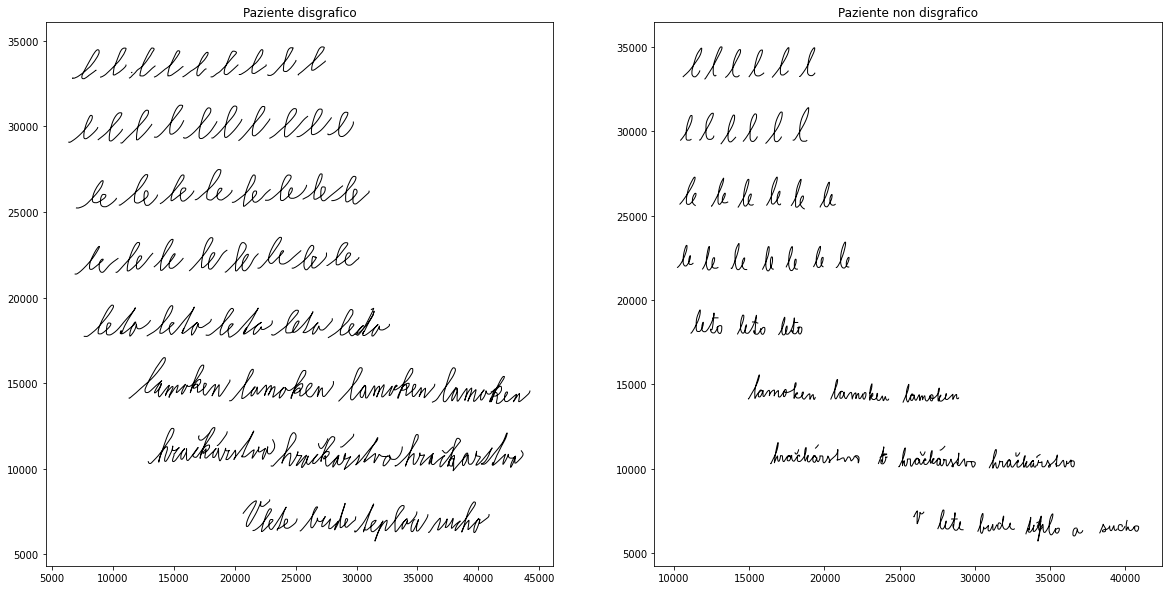

In [ ]:
user_disgrafico = get_Session(5)
user_no_disgrafico = get_Session(24) 

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 10))

ax1.set_title('Paziente disgrafico')
view_image(user_disgrafico,ax1)

ax2.set_title('Paziente non disgrafico')
view_image(user_no_disgrafico,ax2)

# **3 Estrazione features con CNN**

Vogliamo effettuare l'estrazione delle feature con ResNet50 e VGG16, per poi confrontare i risultati ottenuti

Entrambe le reti richiedono un'immagine a colori (3 canali). Tramite le seguenti righe di codice abbiamo verificato il numero di canali delle nostre immagini che è (288, 432, 3):



```
import cv2
img = cv2.imread('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/file/dataset/user00006.png')
img.shape
```

Vogliamo capire come appaiono le features estratte, pertanto definiamo una funzione che carica un'immagine e dopo averla data in input alla rete ritorna le features estratte

In [ ]:
def from_image_to_features(model):
  #cv2 restituisce un oggetto numpy 
  image = cv2.imread('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/file/dataset/user00006.png')

  #Dato che le reti ResNet50 e VGG16 accettano un input con shape (224,224,3), ridimensioniamo l'immagine
  img_reshaped = cv2.resize(image, (224, 224)).reshape(-1, 224, 224, 3)

  #Per soddisfare i requisiti di ResNet50/VGG16, l'immagine deve essere preprocessata
  img_reshaped = preprocess_input(img_reshaped)

  #Estraiamo le feature dall'immagine 
  features = model.predict(img_reshaped)
  #Stampiamo la shape delle features ottenute dall'immagine
  return features

Definiamo una funzione che estrae le features di tutto il dataset e le salva in un dataframe.

In [ ]:
def model_features_extraction(model):
  df = pd.DataFrame()

  for row in range(120) :
     user_id = str(users.iat[row, 0])
     image = cv2.imread('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/file/dataset/user' + user_id + '.png')

     #Non effettuiamo la conversione dell'immagine in un array perché il metodo imread converte già l'immagine in un array
     #Effettuiamo il resize e il reshape dell'immagine perché ResNet50/VGG16 vuole un input shape pari a (1, 224, 224, 3)
     image = cv2.resize(image, (224, 224)).reshape(1, 224, 224, 3)

     #Prepariamo l'immagine per la rete
     image = preprocess_input(image)

     #Estriamo le features
     features = model.predict(image)

      #Inseriamo le features di ogni immagine nel dataframe df1
     df1 = pd.DataFrame(features)

     #Concateniamo ogni df1 ottenuto a df
     df =  pd.concat([df, df1], ignore_index=True)

  return df

## 3.1 Estrazione delle features con ResNet50

In [ ]:
#Carichiamo la rete ResNet50 preaddestrata da cui togliamo l'ultimo layer che serve per la classificazione (ci siamo basati su model.summary())
modelResNet50 = ResNet50()
modelResNet50 = Model(inputs=modelResNet50.inputs, outputs=modelResNet50.layers[-2].output)

In [ ]:
#Vogliamo vedere la shape delle features estratte a partire da una singola immagine
featuresResNet50 = from_image_to_features(modelResNet50)
featuresResNet50.shape

1/1 [==============================] - 0s 205ms/step
<bound method Model.get_layer of <keras.engine.functional.Functional object at 0x7f086c450ee0>>


(1, 2048)

In [ ]:
#Effettuiamo l'estrazione delle features di tutto il dataset
dfResNet50 = model_features_extraction(modelResNet50)

### 3.1.1 Rappresentazione delle features estratte da ResNet50

In [ ]:
#Al dataframe contenente tutte le features estratte aggiungiamo una colonna contenente le labels che ricaviamo dal file users 
#Infine salviamo il dataframe ottenuto come file csv

dfResNet50['diag'] = users['diag']

dfResNet50.to_csv('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/features_extraction/FeatureExtractionResNet50.csv')

In [ ]:
FeatureExtractionResNet50 = pd.read_csv('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/features_extraction/FeatureExtractionResNet50.csv')

#Effettuiamo il drop della colonna 'Unnamed'
FeatureExtractionResNet50.drop(["Unnamed: 0"], axis=1, inplace=True)

#Stampiamo il file FeatureExtractionResNet50.csv ottenuto 
FeatureExtractionResNet50

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,diag
0,0.035744,0.000000,0.009859,0.000000,0.138623,0.003192,0.000000,0.404216,0.0,0.0,...,0.0,0.000000,0.000431,0.000000,0.0,0.0,0.092356,0.147712,0.694410,1
1,0.037265,0.000000,0.038562,0.012777,0.032586,0.003434,0.013395,0.519389,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.056693,0.074798,0.627601,1
2,0.034530,0.000000,0.042751,0.000000,0.003793,0.005088,0.010964,0.423228,0.0,0.0,...,0.0,0.000000,0.000000,0.000902,0.0,0.0,0.052453,0.000000,0.643004,1
3,0.000000,0.000000,0.000000,0.000000,0.015951,0.000000,0.011047,0.458414,0.0,0.0,...,0.0,0.004499,0.028545,0.000000,0.0,0.0,0.089209,0.152708,0.162259,1
4,0.000000,0.000000,0.136538,0.000000,0.016602,0.000000,0.006876,0.369742,0.0,0.0,...,0.0,0.014532,0.001535,0.000000,0.0,0.0,0.104121,0.053432,0.380749,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.202831,0.002547,0.000000,0.000000,0.052115,0.009534,0.029744,0.449765,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.016582,0.090870,0.687225,0
116,0.095793,0.000000,0.000927,0.000000,0.002706,0.000000,0.005256,0.710806,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.054706,0.142027,0.523595,0
117,0.013884,0.000000,0.006067,0.000000,0.070490,0.000000,0.008700,0.538866,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.090544,0.124174,0.170981,0
118,0.009474,0.010007,0.000000,0.000000,0.019084,0.000000,0.000000,0.402219,0.0,0.0,...,0.0,0.001006,0.000000,0.000000,0.0,0.0,0.109892,0.162072,0.365336,0


## 3.2 Estrazione delle features con VGG16

In [ ]:
#Carichiamo la rete VGG16 preaddestrata da cui togliamo l'ultimo layer che serve per la classificazione (ci siamo basati su model.summary())
modelVGG16 = VGG16()
modelVGG16 = Model(inputs=modelVGG16.inputs, outputs=modelVGG16.layers[-2].output)

553467096/553467096 [==============================] - 6s 0us/step


In [ ]:
#Vogliamo vedere la shape delle features estratte a partire da una singola immagine
featuresVGG16 = from_image_to_features(modelVGG16)
featuresVGG16.shape

1/1 [==============================] - 1s 1s/step


(1, 4096)

In [ ]:
#Effettuiamo l'estrazione delle features di tutto il dataset
dfVGG16 = model_features_extraction(modelVGG16)

1/1 [==============================] - 1s 557ms/step


### 3.2.1 Rappresentazione delle features estratte da VGG16

In [ ]:
#Al dataframe contenente tutte le features estratte aggiungiamo una colonna contenente le labels che ricaviamo dal file users 
#Infine salviamo il dataframe ottenuto come file csv

dfVGG16['diag'] = users['diag']

dfVGG16.to_csv('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/features_extraction/FeatureExtractionVGG16.csv')

In [ ]:
FeatureExtractionVGG16 = pd.read_csv('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/features_extraction/FeatureExtractionVGG16.csv')

#Effettuiamo il drop della colonna 'Unnamed'. con inplace = True applichiamo la modifica alla variabile originale
FeatureExtractionVGG16.drop(["Unnamed: 0"], axis=1, inplace=True)
print(FeatureExtractionVGG16._get_value(0,'2054'))
#Stampiamo il file FeatureExtractionVGG16.csv ottenuto 
FeatureExtractionVGG16

0.0


,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,diag
0,0.0,0.192173,0.856219,0.000000,0.0,0.0,0.753882,0.0,0.0,0.0,...,0.0,0.203728,1.984265,0.000000,0.0,0.000000,0.0,0.0,1.307775,1
1,0.0,0.482490,0.971934,0.000000,0.0,0.0,1.363203,0.0,0.0,0.0,...,0.0,0.478929,2.762750,0.000000,0.0,1.072378,0.0,0.0,0.739925,1
2,0.0,0.004178,1.157734,0.087640,0.0,0.0,2.036996,0.0,0.0,0.0,...,0.0,0.816935,2.340591,0.000000,0.0,0.777236,0.0,0.0,0.084976,1
3,0.0,0.000000,0.506833,0.000000,0.0,0.0,0.527084,0.0,0.0,0.0,...,0.0,0.000000,1.294402,0.287871,0.0,0.000000,0.0,0.0,1.706636,1
4,0.0,0.085655,0.871656,0.000000,0.0,0.0,0.798144,0.0,0.0,0.0,...,0.0,0.756709,2.293720,0.000000,0.0,0.000000,0.0,0.0,1.308235,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.0,0.000000,0.729590,0.000000,0.0,0.0,0.512455,0.0,0.0,0.0,...,0.0,0.088575,3.066047,0.000000,0.0,0.000000,0.0,0.0,1.538990,0
116,0.0,0.000000,0.860472,0.000000,0.0,0.0,0.599392,0.0,0.0,0.0,...,0.0,0.571301,3.193656,0.000000,0.0,0.000000,0.0,0.0,1.028268,0
117,0.0,0.329971,0.361802,0.000000,0.0,0.0,0.513774,0.0,0.0,0.0,...,0.0,0.541944,1.975491,0.000000,0.0,0.000000,0.0,0.0,2.049614,0
118,0.0,0.361304,0.322297,0.000000,0.0,0.0,1.881393,0.0,0.0,0.0,...,0.0,0.901802,1.595292,0.000000,0.0,0.252073,0.0,0.0,1.165724,0


#**4 Applicazione della Data Augmentation al dataset originale**

Vogliamo aumentare il numero di istanze del nostro dataset per ridurre l'overfitting riscontrato nella classificazione applicata al dataset originale. Pertanto, modifichiamo il nostro dataset originale applicando diverse strategie di data augmentation: flipping (ribaltamento sia orizzontale che verticale), image rotation, image cropping (zoom su una sezione dell'immagine), add of gaussian noise (sporchiamo l'immagine)

##4.1 Image Flipping

In [ ]:
def orizzontal_vertical_flipping(image):

  #Horizontal Flip
  hflip= iaa.Fliplr(p=1.0)
  input_hf= hflip.augment_image(image)

  #Vertical Flip
  #Il metodo Flipud flippa l'immagine verticalmente
  #Con p indichiamo la probabilità che una determinata immagine venga flippata
  vflip= iaa.Flipud(p = 1.0) 

  #augment_image ritorna l'immagine flippata
  input_vf= vflip.augment_image(image)

  return [input_hf, input_vf]

###4.1.1 Rappresentazione della tecnica utilizzata su una singola immagine


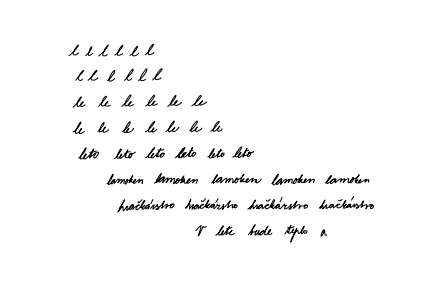
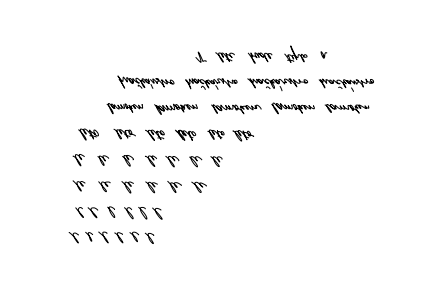
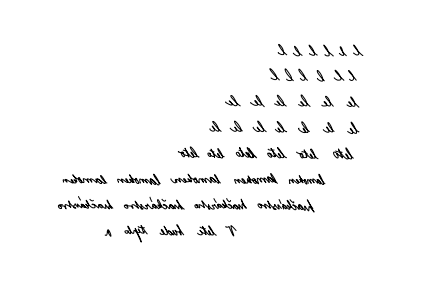


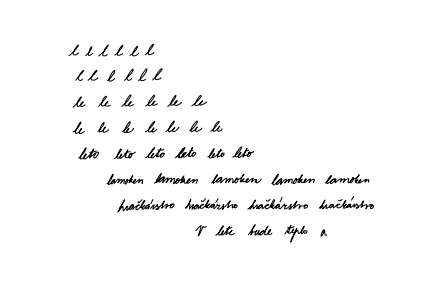
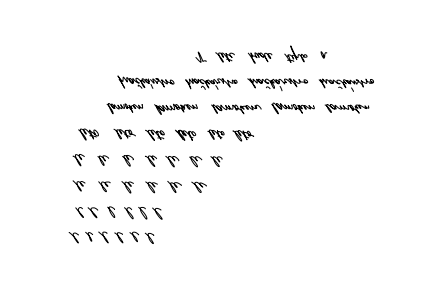
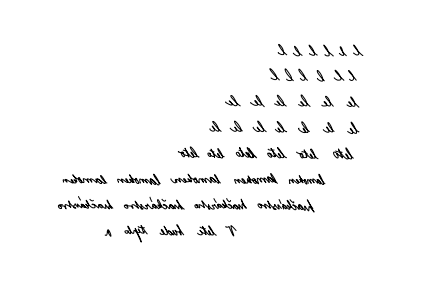

In [ ]:
#Aggiungiamo le immagini modificate al dataset_augmentation, che contiene già le immagini originali
image = cv2.imread('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/file/dataset/user00006.png')
input_hf, input_vf = orizzontal_vertical_flipping(image)

#Mostriamo il risultato della modifica su una singola immagine
images_list=[image, input_vf, input_hf]
labels = ['Original', 'Vertically flipped', 'Horizontally flipped']
ipyplot.plot_images(images_list, labels=labels, img_width=350)

###4.1.2 Salvataggio delle immagini modificate

In [ ]:
# Applichiamo il flipping a tutte le immagini del dataset originale e salviamo le nuove immagini (cartella dataset_flipped)

for i in range(120):
  user_id = str(users.iat[i, 0])
  image = cv2.imread('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/file/dataset_augmentation/dataset_originale/user' + user_id + '.png')
  input_hf, input_vf = orizzontal_vertical_flipping(image)
  input_hf = Image.fromarray(input_hf, 'RGB')
  input_vf = Image.fromarray(input_vf, 'RGB')
  input_hf.save('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/file/dataset_augmentation/dataset_flipped/flipped_horizontal/user' + user_id + '.png')
  input_vf.save('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/file/dataset_augmentation/dataset_flipped/flipped_vertical/user' + user_id + '.png')

##4.2 Image Rotation

In [ ]:
def image_rotation(image):
  rot1 = iaa.Affine(rotate=(-50,20))
  input_rot1 = rot1.augment_image(image)
  return input_rot1
  

###4.2.1 Rappresentazione della tecnica utilizzata su una singola immagine


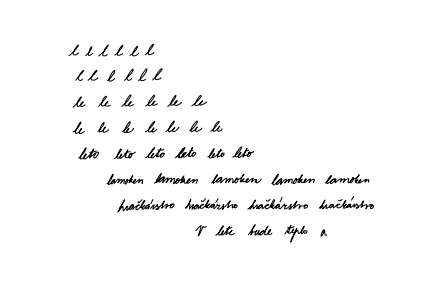
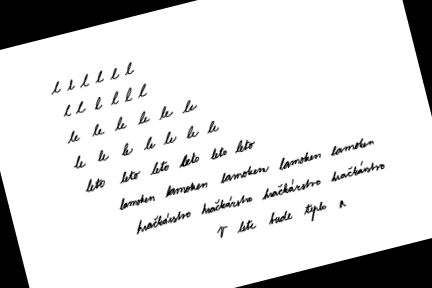


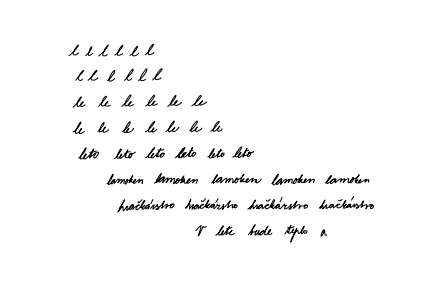
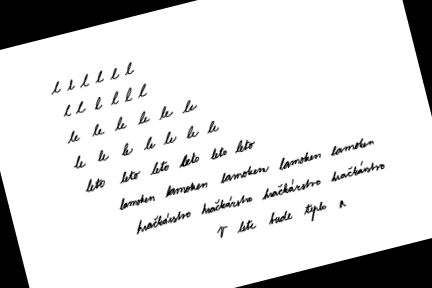

In [ ]:
image = cv2.imread('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/file/dataset/user00006.png')
input_rot1 = image_rotation(image)
images_list = [image,input_rot1]
labels = ['Original', 'Rotated image']
ipyplot.plot_images(images_list,labels=labels,img_width=500)

###4.2.2 Salvataggio delle immagini modificate

In [ ]:
for i in range(120):
  user_id = str(users.iat[i, 0])
  image = cv2.imread('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/file/dataset_augmentation/dataset_originale/user' + user_id + '.png')
  input_rot1 = image_rotation(image)
  input_rot1 = Image.fromarray(input_rot1, 'RGB')
  input_rot1.save('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/file/dataset_augmentation/dataset_rotation/user' + user_id + '.png')

##4.3 Image Cropping

In [ ]:
def image_cropping(image):
  crop1 = iaa.Crop(percent=(0, 0.3)) 
  input_crop1 = crop1.augment_image(image)
  return input_crop1

###4.3.1 Rappresentazione della tecnica utilizzata su una singola immagine


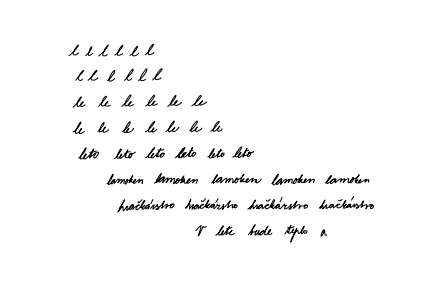
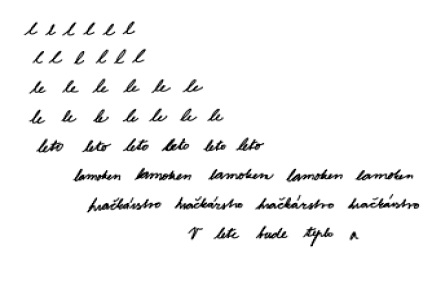


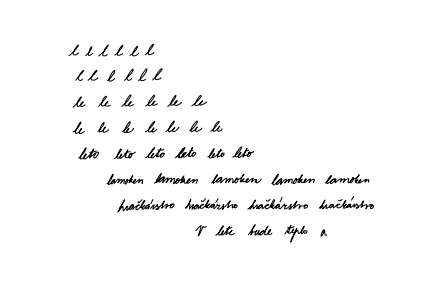
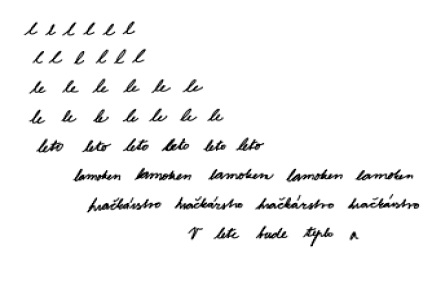

In [ ]:
image = cv2.imread('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/file/dataset/user00006.png')
input_crop1 = image_cropping(image)
images_list = [image,input_crop1]
labels = ['Original', 'Cropped image']
ipyplot.plot_images(images_list,labels=labels,img_width=500)

###4.3.2 Salvataggio delle immagini modificate

In [ ]:
for i in range(120):
  user_id = str(users.iat[i, 0])
  image = cv2.imread('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/file/dataset_augmentation/dataset_originale/user' + user_id + '.png')
  input_crop1 = image_cropping(image)
  input_crop1 = Image.fromarray(input_crop1, 'RGB')
  input_crop1.save('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/file/dataset_augmentation/dataset_cropped/user' + user_id + '.png')

## 4.4 Aggiungiamo rumore gaussiano alle immagini

In [ ]:
def noise(image):
  noise=iaa.AdditiveGaussianNoise(10,40)
  input_noise=noise.augment_image(image)
  return input_noise

###4.4.1 Rappresentazione della tecnica utilizzata su una singola immagine


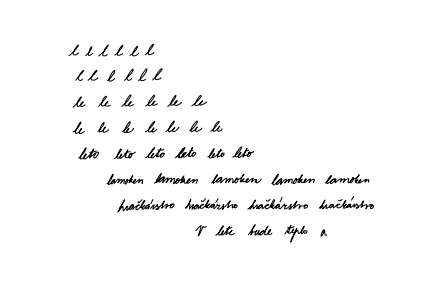
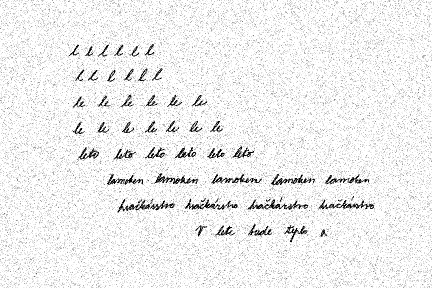


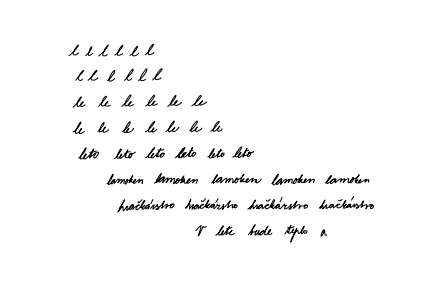
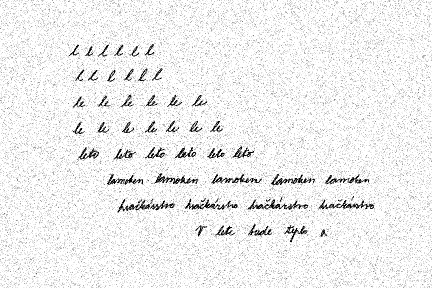

In [ ]:
image = cv2.imread('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/file/dataset/user00006.png')
input_noise = noise(image)
images_list = [image,input_noise]
labels = ['Original', 'Gaussian Noise Image']
ipyplot.plot_images(images_list,labels=labels,img_width=500)

###4.4.2 Salvataggio delle immagini modificate

In [ ]:
for i in range(120):
  user_id = str(users.iat[i, 0])
  image = cv2.imread('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/file/dataset_augmentation/dataset_originale/user' + user_id + '.png')
  input_noise = noise(image)
  input_noise = Image.fromarray(input_noise, 'RGB')
  input_noise.save('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/file/dataset_augmentation/dataset_noise/user' + user_id + '.png')

#**5 Estrazione features con Data Augmentation**


In [ ]:
def model_features_extraction_dataAug(model):
  df = pd.DataFrame()
  list_dataset= ['cropped', 'flipped/flipped_horizontal', 'flipped/flipped_vertical', 'noise', 'originale', 'rotation']
  for row in range(120) :
     user_id = str(users.iat[row, 0])
     for dataset in list_dataset:
       image = cv2.imread('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/file/dataset_augmentation/dataset_'+ dataset +'/user' + user_id + '.png')

       #Non effettuiamo la conversione dell'immagine in un array perché il metodo imread converte già l'immagine in un array
       #Effettuiamo il resize e il reshape dell'immagine perché ResNet50/VGG16 vuole un input shape pari a (1, 224, 224, 3)
       image = cv2.resize(image, (224, 224)).reshape(1, 224, 224, 3)

       #Prepariamo l'immagine per la rete
       image = preprocess_input(image)

       #Estriamo le features
       features = model.predict(image)

       #Inseriamo le features di ogni immagine nel dataframe df1
       df1 = pd.DataFrame(features)

       #Concateniamo ogni df1 ottenuto a df
       df =  pd.concat([df, df1], ignore_index=True)

  return df

In [ ]:
#Al dataframe contenente tutte le features estratte dovremo aggiungere una colonna contenente le labels.
#Per fare ciò, prima di tutto costruiamo un dataframe contenente tutte le labels associate alle 720 righe del nuovo datatset ottenuto applicando la data augmentation.
#Per come abbiamo costruito il dataset ogni gruppo di 6 righe è associato allo stesso user.
#Pertanto, le prime 6 righe sono associate allo user00006, le seconde 6 righe sono associate allo user00007,......., le ultime 6 righe sono associate allo user00192

list_value = []
for row in range(120):
  user_id = str(users.iat[row, 0])
  cont = 0
  while cont !=6 :
    list_value.append(users['diag'][row])
    cont = cont + 1

df_diag = pd.DataFrame({'diag' : list_value})

##5.1 Estrazione delle features con ResNet50

In [ ]:
#Carichiamo la rete ResNet50 preaddestrata da cui togliamo l'ultimo layer che serve per la classificazione (ci siamo basati su model.summary())
modelResNet50_aug = ResNet50()
modelResNet50_aug = Model(inputs=modelResNet50_aug.inputs, outputs=modelResNet50_aug.layers[-2].output)

In [ ]:
#Effettuiamo l'estrazione delle features di tutto il dataset
dfResNet50_aug = model_features_extraction_dataAug(modelResNet50_aug)

### 5.1.1 Rappresentazione delle features estratte da ResNet50

In [ ]:
#Associamo il dataframe df_diag contenente le labels al dataframe contenente le feature estratte dalla rete
dfResNet50_aug['diag'] = df_diag['diag']

In [ ]:
#Infine salviamo il dataframe ottenuto come file csv
dfResNet50_aug.to_csv('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/features_extraction/FeatureExtractionDataAugmentationResNet50.csv')

In [ ]:
FeatureExtractionResNet50_aug = pd.read_csv('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/features_extraction/FeatureExtractionDataAugmentationResNet50.csv')

#Effettuiamo il drop della colonna 'Unnamed'
FeatureExtractionResNet50_aug.drop(["Unnamed: 0"], axis=1, inplace=True)

#Stampiamo il file FeatureExtractionResNet50.csv ottenuto 
FeatureExtractionResNet50_aug

##5.2 Estrazione delle features con VGG16

In [ ]:
#Carichiamo la rete VGG16 preaddestrata da cui togliamo l'ultimo layer che serve per la classificazione (ci siamo basati su model.summary())
modelVGG16_aug = VGG16()
modelVGG16_aug = Model(inputs=modelVGG16_aug.inputs, outputs=modelVGG16_aug.layers[-2].output)

In [ ]:
#Effettuiamo l'estrazione delle features di tutto il dataset
dfVGG16_aug = model_features_extraction_dataAug(modelVGG16_aug)

### 5.2.1 Rappresentazione delle features estratte da VGG16

In [ ]:
#Associamo il dataframe df_diag contenente le labels al dataframe contenente le feature estratte dalla rete
#Infine salviamo il dataframe ottenuto come file csv

dfVGG16_aug['diag'] = df_diag['diag']

dfVGG16_aug.to_csv('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/features_extraction/FeatureExtractionDataAugmentationVGG16.csv')

In [ ]:
FeatureExtractionVGG16_aug = pd.read_csv('/content/drive/MyDrive/ProgettoML/ProgettoDisgrafia/features_extraction/FeatureExtractionDataAugmentationVGG16.csv')

#Effettuiamo il drop della colonna 'Unnamed'. con inplace = True applichiamo la modifica alla variabile originale
FeatureExtractionVGG16_aug.drop(["Unnamed: 0"], axis=1, inplace=True)

#Stampiamo il file FeatureExtractionVGG16.csv ottenuto 
FeatureExtractionVGG16_aug